# Análisis de la Actividad de los Alumnos en el Campus Virtual
-----------------------------------

In [1]:
from SPARQLWrapper import SPARQLWrapper, CSV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from io import StringIO
import warnings
from joblib import dump

#### Declaración del endpoint de SPARQL

In [2]:
sparql = SPARQLWrapper("http://localhost:5820/campus/query")
sparql.setCredentials('admin', 'admin')

#### Declaración de la función que dibuja una gráfica de barras

In [3]:
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='b')
    plt.xlabel('')
    plt.ylabel('count',fontsize=10)

#### Declaración de la función que dibuja la matriz de confusión

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize = False,
                          title = None,
                          cmap = plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Cálculo de la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    # Cálculo de los diferentes grupos
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           xticklabels = classes, yticklabels = classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
             rotation_mode = "anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

# 1. Primera inspección de los datos

#### Consulta de todos los datos del registro de eventos

In [5]:
sparql.setQuery("""
SELECT ?id ?eventname ?component ?action ?target ?objecttable ?objectid ?edulevel ?contextid ?contextlevel
	   ?contextinstanceid ?userid ?courseid ?relateduserid ?anonymous ?timecreated ?origin ?realuserid
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logid> ?id .
    ?x <http://khaos.uma.es/ontologies/moodle/logeventname> ?eventname.
  	?x <http://khaos.uma.es/ontologies/moodle/logcomponent> ?component.
    ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action.
    ?x <http://khaos.uma.es/ontologies/moodle/logtarget> ?target.
    ?x <http://khaos.uma.es/ontologies/moodle/logobjecttable> ?objecttable.
    OPTIONAL{?x <http://khaos.uma.es/ontologies/moodle/logobjectid> ?objectid.}
    ?x <http://khaos.uma.es/ontologies/moodle/logcrud> ?crud.
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel.
    ?x <http://khaos.uma.es/ontologies/moodle/logcontextid> ?contextid.
    ?x <http://khaos.uma.es/ontologies/moodle/logcontextlevel> ?contextlevel.
    ?x <http://khaos.uma.es/ontologies/moodle/logcontextinstanceid> ?contextinstanceid.
    OPTIONAL{?x <http://khaos.uma.es/ontologies/moodle/recordUser> ?userid.}
    ?x <http://khaos.uma.es/ontologies/moodle/recordCourse> ?courseid.
    OPTIONAL{?x <http://khaos.uma.es/ontologies/moodle/recordUserRelated> ?relateduserid.}
    ?x <http://khaos.uma.es/ontologies/moodle/loganonymous> ?anonymous.
    ?x <http://khaos.uma.es/ontologies/moodle/logtimecreated> ?timecreated.
    ?x <http://khaos.uma.es/ontologies/moodle/logorigin> ?origin.
    OPTIONAL{?x <http://khaos.uma.es/ontologies/moodle/recordUserReal> ?realuserid}
}
""")

#### Conversión de los resultados a formato CSV

In [6]:
sparql.setReturnFormat(CSV)
results_log = sparql.query().convert()
s=str(results_log,'utf-8')
data = StringIO(s)

#### *Datos disponibles en: \datos\1-Inspección de los datos\pd_log_all.csv*

In [7]:
pd_log_all = pd.read_csv(data)
pd_log_all.head()

,id,eventname,component,action,target,objecttable,objectid,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,timecreated,origin,realuserid
0,25076215,\core\event\user_updated,core,updated,user,user,13883.0,0,231496,30,13883,http://khaos.uma.es/ontologies/moodle/user12304,http://khaos.uma.es/ontologies/moodle/course128,http://khaos.uma.es/ontologies/moodle/user12450,0,2017-10-01T04:24:55,cli,NaN
1,25081601,\core\event\user_updated,core,updated,user,user,15002.0,0,259051,30,15002,http://khaos.uma.es/ontologies/moodle/user12304,http://khaos.uma.es/ontologies/moodle/course128,http://khaos.uma.es/ontologies/moodle/user8272,0,2017-10-01T04:30:27,cli,NaN
2,25075752,\core\event\user_loggedin,core,loggedin,user,user,14730.0,0,1,10,0,http://khaos.uma.es/ontologies/moodle/user14297,http://khaos.uma.es/ontologies/moodle/course128,NaN,0,2017-10-01T04:18:07,web,NaN
3,25076712,\core\event\user_updated,core,updated,user,user,15107.0,0,259679,30,15107,http://khaos.uma.es/ontologies/moodle/user12304,http://khaos.uma.es/ontologies/moodle/course128,http://khaos.uma.es/ontologies/moodle/user5433,0,2017-10-01T04:25:24,cli,NaN
4,25079429,\core\event\user_updated,core,updated,user,user,13778.0,0,230298,30,13778,http://khaos.uma.es/ontologies/moodle/user12304,http://khaos.uma.es/ontologies/moodle/course128,http://khaos.uma.es/ontologies/moodle/user2076,0,2017-10-01T04:28:19,cli,NaN


#### Gráfica del número de eventos por tipo de usuario

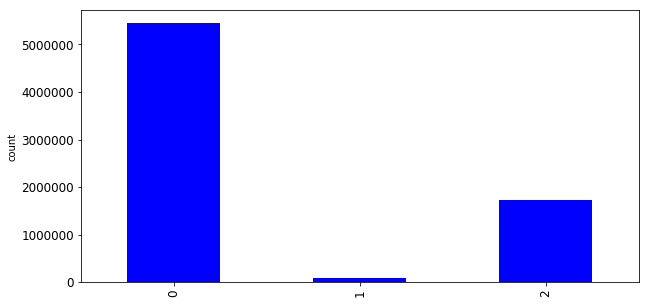

In [8]:
plotdat(pd_log_all,'edulevel')

#### Filtro los resultados a los eventos relacionados con los alumnos

#### *Datos disponibles en: \datos\1-Inspección de los datos\pd_log_students.csv*

In [9]:
pd_log_students = pd_log_all[pd_log_all.edulevel == 2]
pd_log_students.head()

,id,eventname,component,action,target,objecttable,objectid,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,timecreated,origin,realuserid
83,25075240,\core\event\course_viewed,core,viewed,course,None,NaN,2,265304,50,3271,http://khaos.uma.es/ontologies/moodle/user11550,http://khaos.uma.es/ontologies/moodle/course30,NaN,0,2017-10-01T03:08:27,web,NaN
109,25075028,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,NaN,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T02:59:05,web,NaN
119,25073410,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,NaN,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T00:16:56,web,NaN
130,25073562,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,NaN,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T00:37:12,web,NaN
179,25073549,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,http://khaos.uma.es/ontologies/moodle/user2380,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T00:36:28,web,NaN


#### Gráfica del número de acciones realizadas por los alumnos

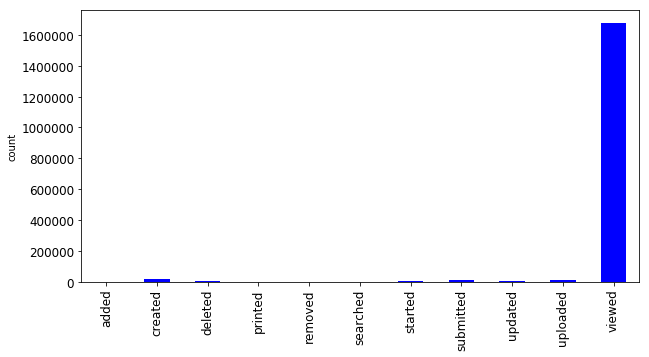

In [10]:
plotdat(pd_log_students,'action')

#### Filtro los datos para ver los contenidos que visualizan los alumnos

#### *Datos disponibles en: \datos\1-Inspección de los datos\pd_log_students_viewed.csv*

In [11]:
pd_log_students_viewed = pd_log_students[pd_log_students.action == 'viewed']
pd_log_students_viewed.head()

,id,eventname,component,action,target,objecttable,objectid,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,timecreated,origin,realuserid
83,25075240,\core\event\course_viewed,core,viewed,course,None,NaN,2,265304,50,3271,http://khaos.uma.es/ontologies/moodle/user11550,http://khaos.uma.es/ontologies/moodle/course30,NaN,0,2017-10-01T03:08:27,web,NaN
109,25075028,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,NaN,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T02:59:05,web,NaN
119,25073410,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,NaN,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T00:16:56,web,NaN
130,25073562,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,NaN,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T00:37:12,web,NaN
179,25073549,\core\event\course_viewed,core,viewed,course,None,NaN,2,290,50,1,http://khaos.uma.es/ontologies/moodle/user2380,http://khaos.uma.es/ontologies/moodle/course129,NaN,0,2017-10-01T00:36:28,web,NaN


#### Gráfica de los contenidos que visualizan los alumnos

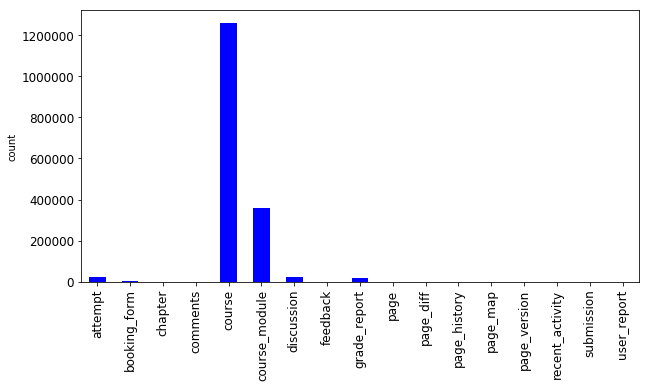

In [12]:
plotdat(pd_log_students_viewed,'target')

#### Filtro los contenidos que entregan los alumnos

#### *Datos disponibles en: \datos\1-Inspección de los datos\pd_log_students_submitted.csv*

In [13]:
pd_log_students_submitted = pd_log_students[pd_log_students.action == 'submitted']
pd_log_students_submitted.head()

,id,eventname,component,action,target,objecttable,objectid,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,timecreated,origin,realuserid
53542,25144980,\mod_assign\event\assessable_submitted,mod_assign,submitted,assessable,assign_submission,421776.0,2,269017,70,243971,http://khaos.uma.es/ontologies/moodle/user1340,http://khaos.uma.es/ontologies/moodle/course33,NaN,0,2017-10-02T12:37:54,web,NaN
53550,25144400,\mod_assign\event\assessable_submitted,mod_assign,submitted,assessable,assign_submission,421759.0,2,269017,70,243971,http://khaos.uma.es/ontologies/moodle/user7819,http://khaos.uma.es/ontologies/moodle/course33,NaN,0,2017-10-02T12:34:59,web,NaN
53800,25144239,\mod_assign\event\assessable_submitted,mod_assign,submitted,assessable,assign_submission,421754.0,2,269017,70,243971,http://khaos.uma.es/ontologies/moodle/user2611,http://khaos.uma.es/ontologies/moodle/course33,NaN,0,2017-10-02T12:34:05,web,NaN
53965,25144726,\mod_assign\event\assessable_submitted,mod_assign,submitted,assessable,assign_submission,421767.0,2,269017,70,243971,http://khaos.uma.es/ontologies/moodle/user7371,http://khaos.uma.es/ontologies/moodle/course33,NaN,0,2017-10-02T12:35:57,web,NaN
54027,25144652,\mod_assign\event\assessable_submitted,mod_assign,submitted,assessable,assign_submission,421748.0,2,269017,70,243971,http://khaos.uma.es/ontologies/moodle/user431,http://khaos.uma.es/ontologies/moodle/course33,NaN,0,2017-10-02T12:35:40,web,NaN


#### Visualizo el número de tipos de entregas

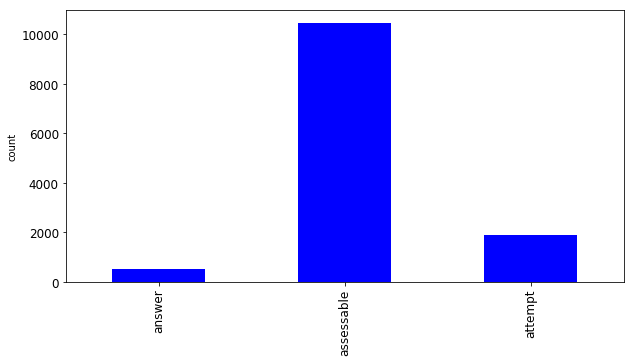

In [14]:
plotdat(pd_log_students_submitted,'target')

# 2. Análisis de grupos de usuarios
-------------------------------------------------------------------
## 2.1 Obtención de los datos
### Consulta con el número de visualizaciones por usuario y asignatura

In [15]:
sparql.setQuery("""
SELECT (COUNT(*) AS ?count_viewed) ?userid ?courseid
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action. FILTER (?action = 'viewed')
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel. FILTER (?edulevel = 2)
    ?x <http://khaos.uma.es/ontologies/moodle/recordUser> ?userid.
    ?x <http://khaos.uma.es/ontologies/moodle/recordCourse> ?courseid.
}GROUP BY ?action ?edulevel ?userid ?courseid

""")

#### Conversión de los resultados a formato CSV

In [16]:
sparql.setReturnFormat(CSV)
views_course_user = sparql.query().convert()
s=str(views_course_user,'utf-8')
data = StringIO(s)

#### *Datos disponibles en: \datos\2-Análisis de grupos de usuarios\views_course_user.csv*

In [17]:
views_course_user = pd.read_csv(data)
views_course_user.head()

,count_viewed,userid,courseid
0,464,http://khaos.uma.es/ontologies/moodle/user14261,http://khaos.uma.es/ontologies/moodle/course49
1,203,http://khaos.uma.es/ontologies/moodle/user5216,http://khaos.uma.es/ontologies/moodle/course36
2,38,http://khaos.uma.es/ontologies/moodle/user6285,http://khaos.uma.es/ontologies/moodle/course79
3,278,http://khaos.uma.es/ontologies/moodle/user4582,http://khaos.uma.es/ontologies/moodle/course68
4,81,http://khaos.uma.es/ontologies/moodle/user11311,http://khaos.uma.es/ontologies/moodle/course30


### Consulta con el número de entregas por usuario y asignatura

In [18]:
sparql.setQuery("""
SELECT (COUNT(*) AS ?count_submission) ?userid ?courseid
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action. FILTER (?action = 'submitted')
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel. FILTER (?edulevel = 2)
    ?x <http://khaos.uma.es/ontologies/moodle/recordUser> ?userid.
    ?x <http://khaos.uma.es/ontologies/moodle/recordCourse> ?courseid.
}GROUP BY ?action ?edulevel ?userid ?courseid

""")

#### Conversión de los resultados a formato CSV

In [19]:
sparql.setReturnFormat(CSV)
submissions_course_user = sparql.query().convert()
s=str(submissions_course_user,'utf-8')
data = StringIO(s)

#### Datos disponibles en: *\datos\2-Análisis de grupos de usuarios\submissions_course_user.csv*

In [20]:
submissions_course_user = pd.read_csv(data)
submissions_course_user.head()

,count_submission,userid,courseid
0,1,http://khaos.uma.es/ontologies/moodle/user15846,http://khaos.uma.es/ontologies/moodle/course10
1,8,http://khaos.uma.es/ontologies/moodle/user21,http://khaos.uma.es/ontologies/moodle/course39
2,22,http://khaos.uma.es/ontologies/moodle/user6167,http://khaos.uma.es/ontologies/moodle/course42
3,24,http://khaos.uma.es/ontologies/moodle/user7497,http://khaos.uma.es/ontologies/moodle/course9
4,9,http://khaos.uma.es/ontologies/moodle/user999,http://khaos.uma.es/ontologies/moodle/course5


### Unión de las visualizaciones y entregas, realizadas por usuario y asignaturas

#### *Datos disponibles en: \datos\2-Análisis de grupos de usuarios\pd_log_submission_views.csv*

In [21]:
pd_log_submission_views = pd.merge(submissions_course_user, views_course_user, on = ['userid', 'courseid'])
pd_log_submission_views = pd_log_submission_views.replace(to_replace ='http://khaos.uma.es/ontologies/moodle/user', value = '', regex = True)
pd_log_submission_views = pd_log_submission_views.replace(to_replace ='http://khaos.uma.es/ontologies/moodle/course', value = '', regex = True)
pd_log_submission_views.head()

,count_submission,userid,courseid,count_viewed
0,1,15846,10,442
1,8,21,39,726
2,22,6167,42,438
3,24,7497,9,266
4,9,999,5,362


### Representación del número de visualizaciones y entregas por curso y usuario

#### *Gráficas disponibles en: \datos\2-Análisis de grupos de usuarios\plot_courses*

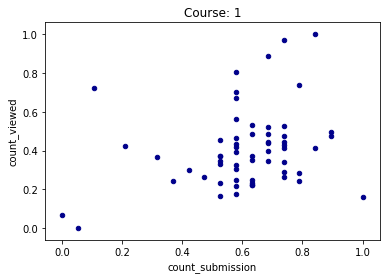

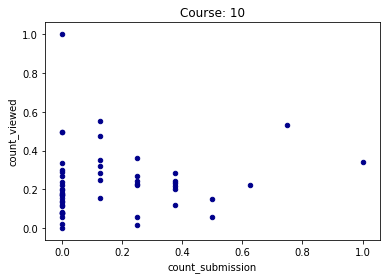

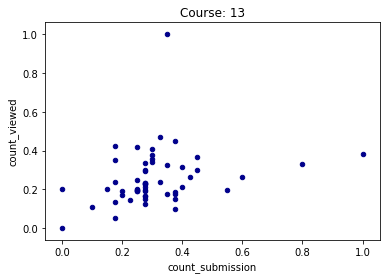

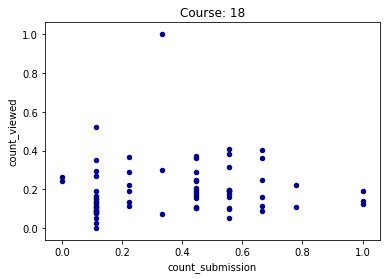

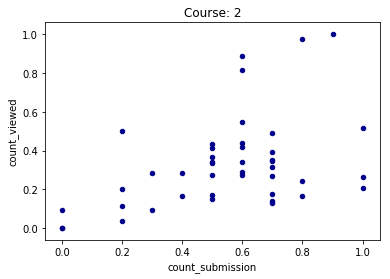

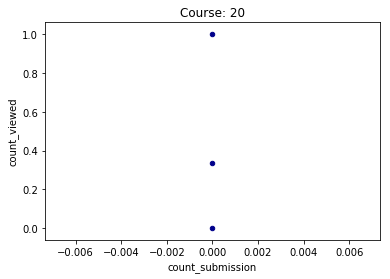

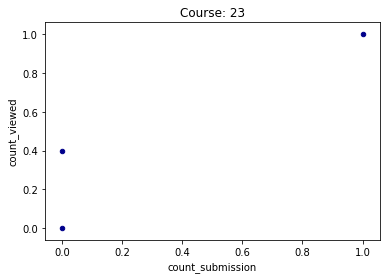

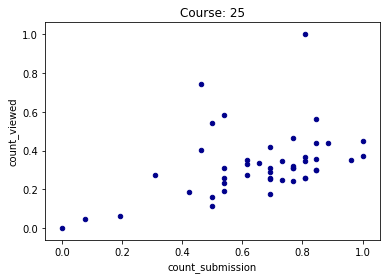

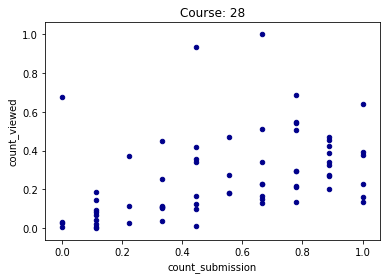

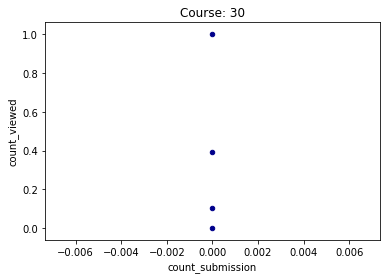

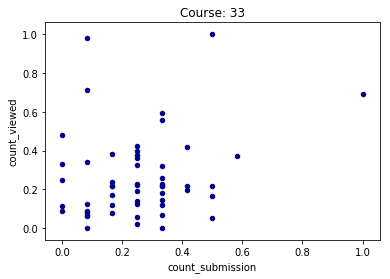

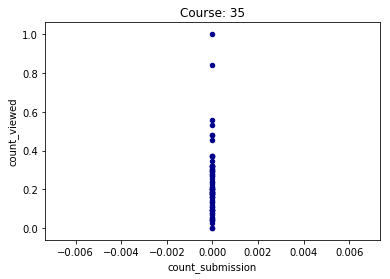

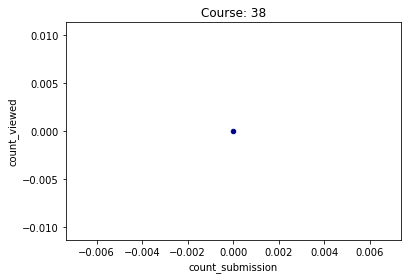

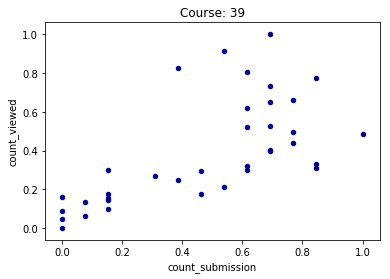

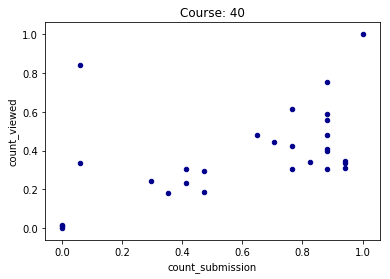

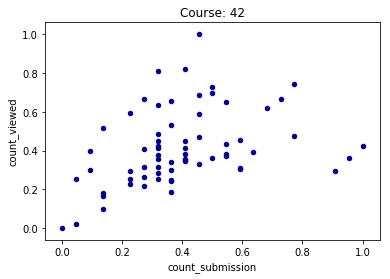

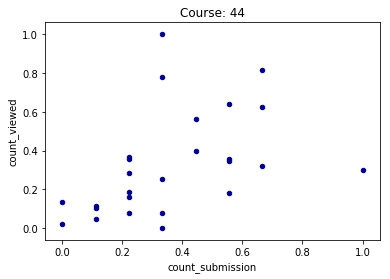

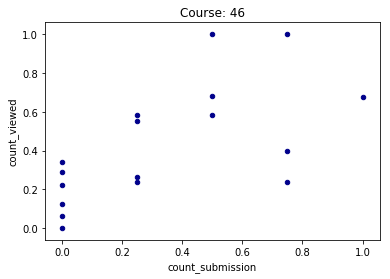

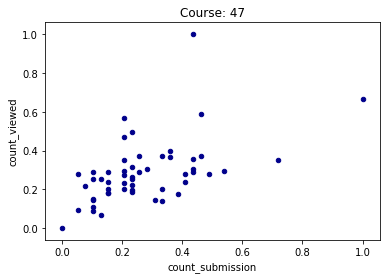

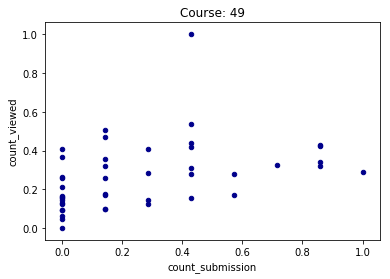

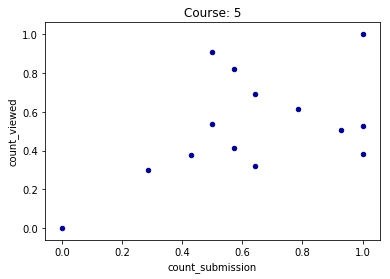

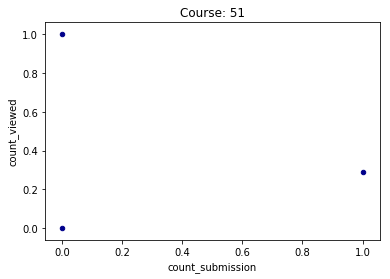

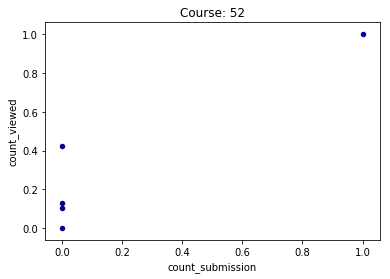

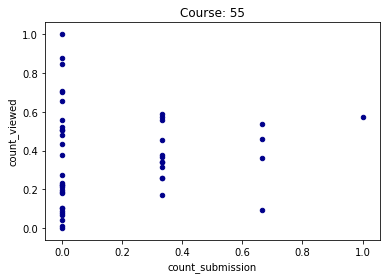

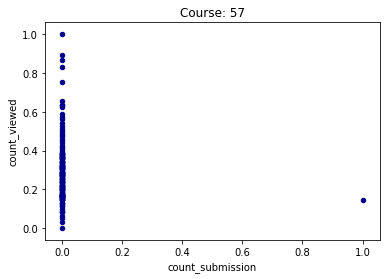

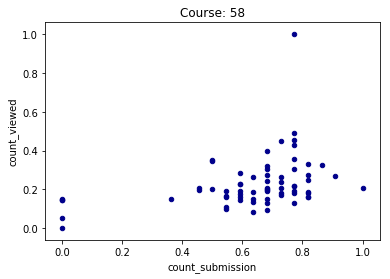

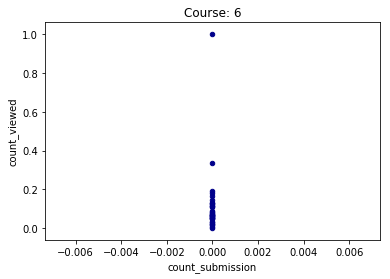

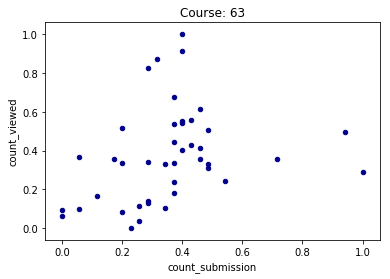

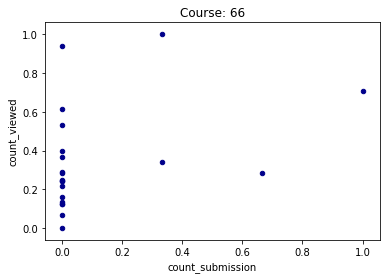

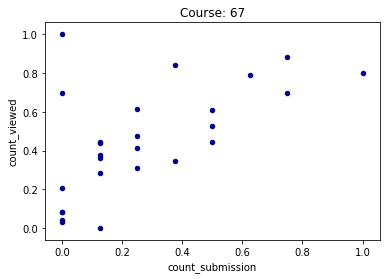

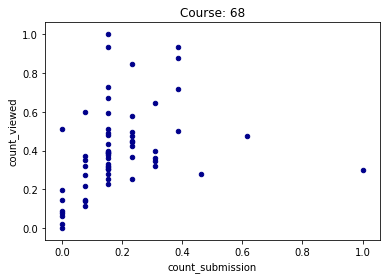

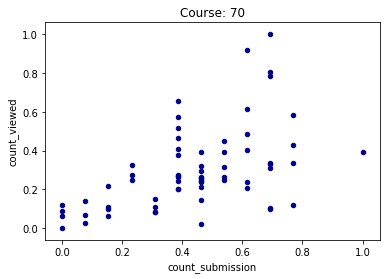

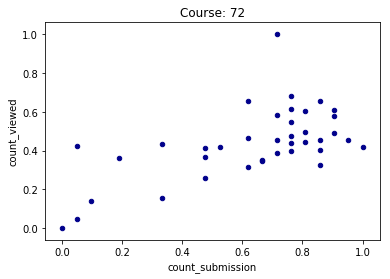

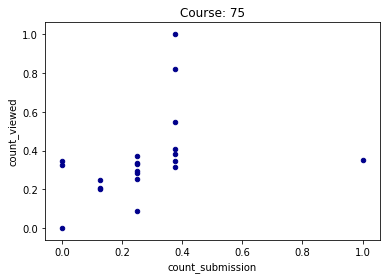

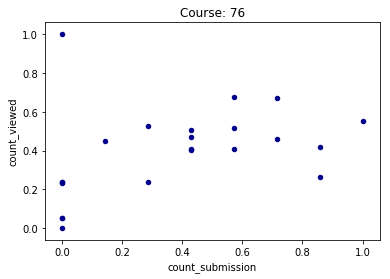

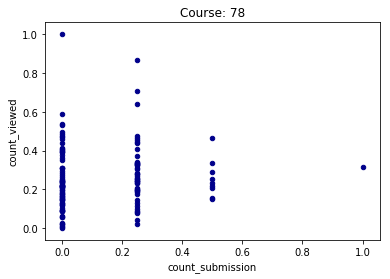

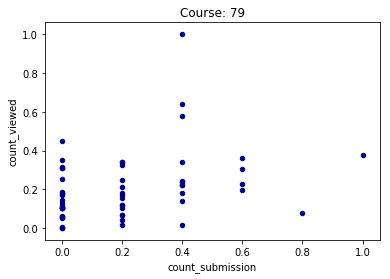

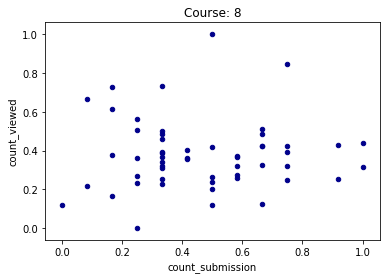

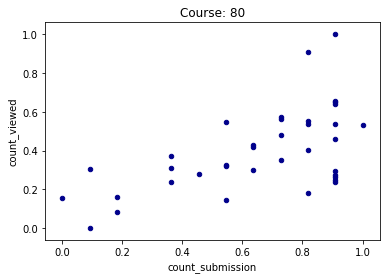

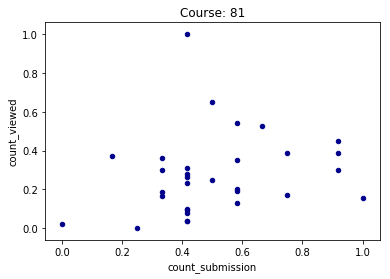

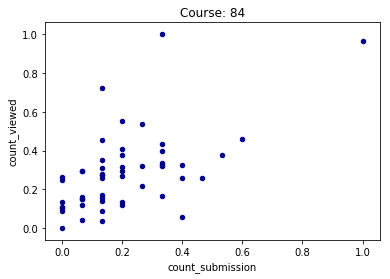

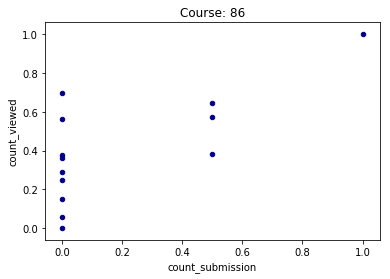

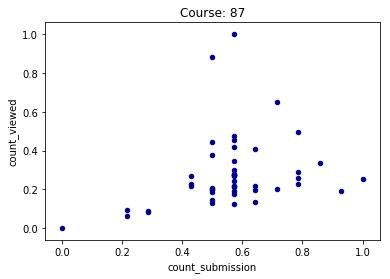

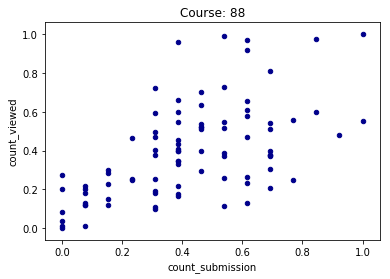

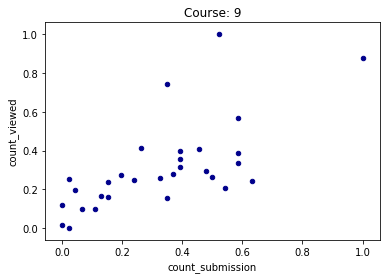

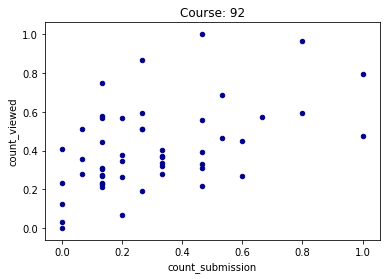

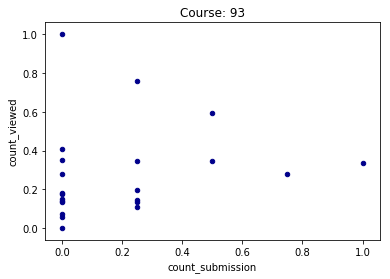

In [22]:
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings('ignore')
courses = np.unique(pd_log_submission_views['courseid'])
for i in range(len(courses)):
    df_course =  pd_log_submission_views[pd_log_submission_views['courseid'] == courses[i]].astype(float)
    transformer = MinMaxScaler().fit(df_course)
    df_course= transformer.transform(df_course)
    df_course = pd.DataFrame({'count_submission':df_course[:,0], 'count_viewed':df_course[:,3]})
    ax1 = df_course.plot.scatter(x='count_submission', y='count_viewed', title='Course: '+courses[i], c='DarkBlue')

### Representación del número de visualizaciones y entregas en todos los cursos

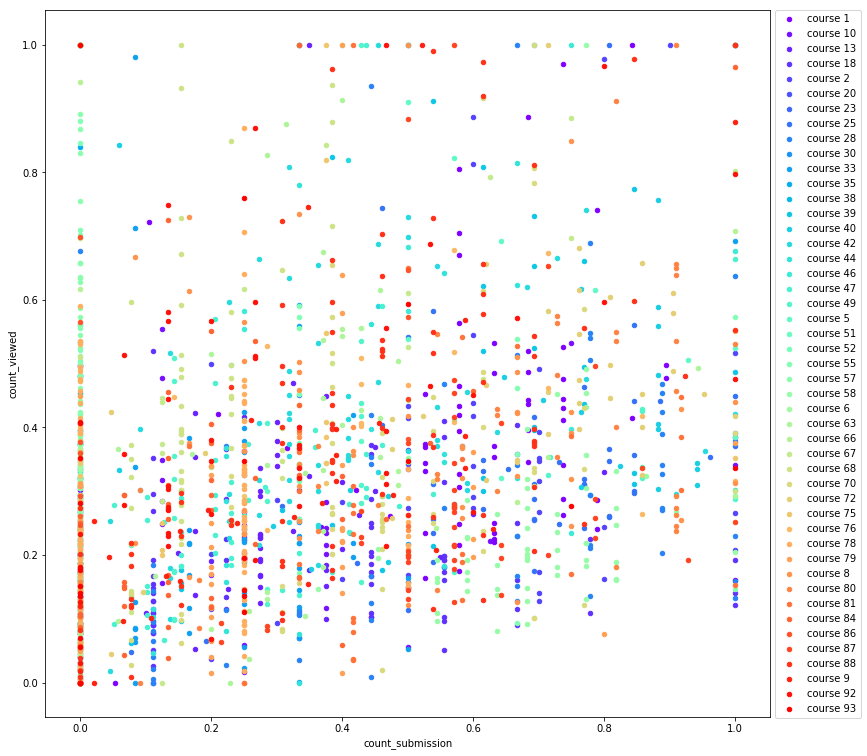

In [23]:
courses = np.unique(pd_log_submission_views['courseid'])
colors = cm.rainbow(np.linspace(0, 1, len(courses)))
padding = 0.003
for i in range(len(courses)): 
    df_def_cur =  pd_log_submission_views[pd_log_submission_views['courseid'] == courses[i]].astype(float)
    transformer = MinMaxScaler().fit(df_def_cur)
    df_def_cur= transformer.transform(df_def_cur)
    df_def_cur = pd.DataFrame({'count_submission':df_def_cur[:,0], 'count_viewed':df_def_cur[:,3]})
    if i == 0: 
        ax = df_def_cur.plot.scatter(x = 'count_submission', y = 'count_viewed',c = [colors[i]] ,label='course '+courses[i], figsize = (13,13))
    else: 
        ax = df_def_cur.plot.scatter(x = 'count_submission', y = 'count_viewed',c = [colors[i]] ,label='course '+courses[i], figsize = (13,13), ax = ax)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## 2.2 Agrupación con K-means

#### Normalización de los datos

#### *Datos disponibles en: \datos\2-Análisis de grupos de usuarios\normalizer.csv*

In [24]:
courses = np.unique(pd_log_submission_views['courseid'])
normalizer = pd.DataFrame()
for i in range(len(courses)):
    sub_submission_views =  pd_log_submission_views[pd_log_submission_views['courseid'] == courses[i]].astype(float)
    transformer = MinMaxScaler().fit(sub_submission_views)
    sub_submission_views= transformer.transform(sub_submission_views)
    sub_submission_views = pd.DataFrame({'count_submission':sub_submission_views[:,0], 'count_viewed':sub_submission_views[:,3]})
    normalizer = normalizer.append(sub_submission_views)
normalizer.head()

,count_submission,count_viewed
0,0.631579,0.532729
1,0.631579,0.234642
2,0.578947,0.805639
3,0.368421,0.243706
4,0.631579,0.249748


#### Ejecución del algoritmo de agrupamiento K-means

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(normalizer)
y = kmeans.labels_
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[2 2 1 ... 1 0 3]
[[0.37804707 0.27695889]
 [0.36415502 0.77225917]
 [0.76885998 0.38593809]
 [0.04314224 0.19635439]]


### Representación de los grupos

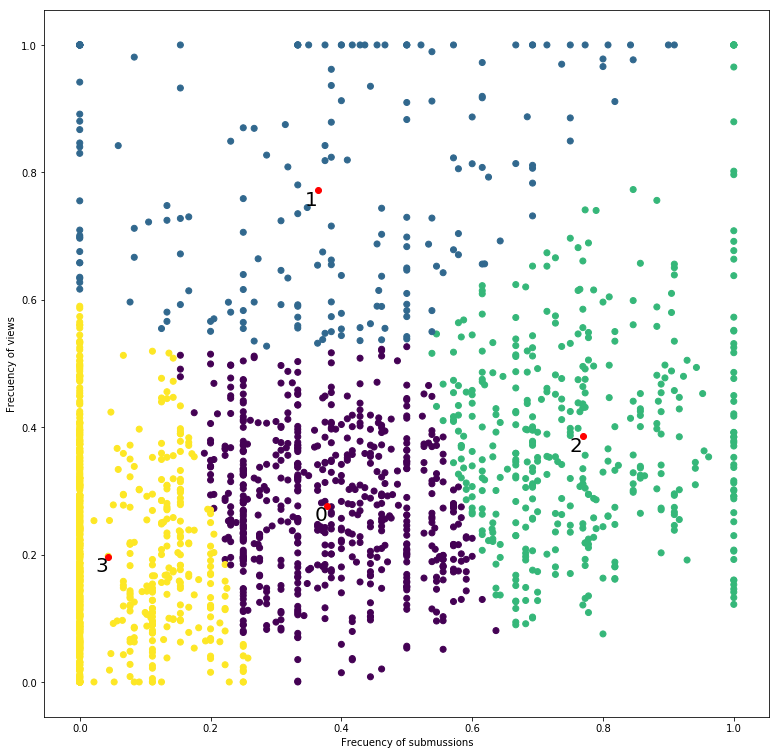

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,13))
X=normalizer.values
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='red')
for i in range(len(np.unique(kmeans.labels_))):
    xy=(kmeans.cluster_centers_[i, 0],kmeans.cluster_centers_[i, 1])
    plt.annotate(i,xy, horizontalalignment='right', verticalalignment='top',fontsize=20)
plt.ylabel('Frecuency of views')
plt.xlabel('Frecuency of submussions')
plt.show()

## 2.3 Predicción con KNeighborsClassifier  

#### División del conjunto de datos en entrenamiento y verificación

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , stratify = y, random_state = 13)

#### Entrenamiento del modelo predictor

#### *Modelo entrenado disponible en: \datos\2-Análisis de grupos de usuarios\campusKNN.joblib*

In [28]:
#Create KNeighborsClassifier
plKNN = Pipeline([('myKNN', KNeighborsClassifier())])

#Create param_grid with differents values for n_neighbors, metric, weights and p
param_grid_KNN = {'myKNN__n_neighbors': [4], 'myKNN__metric':['euclidean','manhattan','minkowski'],
                  'myKNN__weights':['uniform','distance'], 'myKNN__p':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17,30],
                  'myKNN__leaf_size':[2,3,5,7,9,13,17,21,27,30,35,45]}

#Create arrays for save scores and parameteres of the model

#Create labels for use in the confussion matrix
target_names = np.unique(y)
    
print('»»——————————————————————　✭ KNeighborsClassifier ✭　——————————————————————««')
    
    #Create miGSV with GridSearchCV
myGSV_KNN = GridSearchCV(plKNN, param_grid = param_grid_KNN, scoring = 'accuracy',
                         cv = StratifiedKFold(n_splits = 15, random_state = 13), n_jobs = - 1, iid = True,
                         return_train_score = True)
        
#Train model with variable X_train and y_train
myGSV_KNN.fit(X_train, y_train)
    
#Train model with the best estimator parameters
myGSV_KNN.best_estimator_.fit(X_train, y_train)

#Save model with the best estimator parameters
dump(myGSV_KNN.best_estimator_, 'campusKNN.joblib') 
   
#Predict with the variable X_test.
y_pred_KNN = myGSV_KNN.predict(X_test)
   
print('Mejor configuración del modelo: ' + str(myGSV_KNN.best_estimator_))

»»——————————————————————　✭ KNeighborsClassifier ✭　——————————————————————««
Mejor configuración del modelo: Pipeline(memory=None,
         steps=[('myKNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=2,
                                      metric='euclidean', metric_params=None,
                                      n_jobs=None, n_neighbors=4, p=2,
                                      weights='distance'))],
         verbose=False)


### Evaluación de la precisión del modelo

Precisión en la verificación del modelo: 99.17763157894737 %
Mejor precisión obtenida en el entrenamiento: 98.8716502115656 %


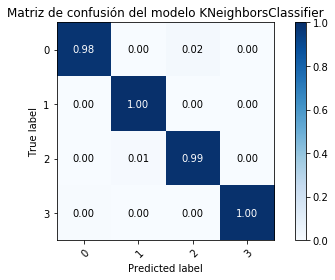

In [29]:
print("Precisión en la verificación del modelo: " + str(100 - (100 * sum(y_pred_KNN != y_test)/len(y_test))), '%')
print('Mejor precisión obtenida en el entrenamiento: ' + str(100 * myGSV_KNN.best_score_), '%')
plot_confusion_matrix(y_test, y_pred_KNN, classes = target_names, normalize = True,
                          title = 'Matriz de confusión del modelo KNeighborsClassifier')
plt.show()

# 3. Análisis temporal
-------------------------------------------------------------------
## 3.1 Análisis de las visualizaciones por fecha
### Consulta con el número de visualizaciones por fecha

In [30]:
sparql.setQuery("""
SELECT (COUNT(*) AS ?count_viewed) ?timecreated
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action. FILTER (?action = 'viewed')
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel. FILTER (?edulevel = 2)
    ?x <http://khaos.uma.es/ontologies/moodle/logtimecreated> ?timecreated.
}GROUP BY ?action ?edulevel ?timecreated

""")

#### Conversión de los resultados a formato CSV

In [31]:
sparql.setReturnFormat(CSV)
results_log_view = sparql.query().convert()
s=str(results_log_view,'utf-8')
data = StringIO(s)

In [32]:
results_log_count_view = pd.read_csv(data)
results_log_count_view.head()

,count_viewed,timecreated
0,2,2017-11-13T16:59:54
1,1,2017-11-06T09:46:15
2,1,2017-11-27T12:57:51
3,1,2018-01-01T17:28:45
4,1,2017-10-26T09:01:03


#### Agrupación de los resultados por semanas

In [33]:
results_log_count_view['Date'] = pd.to_datetime(results_log_count_view['timecreated'])
results_log_count_view_group = results_log_count_view[['count_viewed', 'Date']]
res_views = results_log_count_view_group.groupby([pd.Grouper(key='Date', freq='W-MON')])['count_viewed'].sum()
res_views

Date
2017-10-02    22426
2017-10-09    86786
2017-10-16    75499
2017-10-23    95092
2017-10-30    96748
2017-11-06    82359
2017-11-13    99349
2017-11-20    97806
2017-11-27    83967
2017-12-04    87996
2017-12-11    58885
2017-12-18    87513
2017-12-25    49510
2018-01-01    20491
2018-01-08    41803
2018-01-15    91232
2018-01-22    95562
2018-01-29    89329
2018-02-05    97053
2018-02-12    53550
2018-02-19    62516
2018-02-26    88620
2018-03-05    15510
Freq: W-MON, Name: count_viewed, dtype: int64

###  Representación del número de visualizaciones por semana

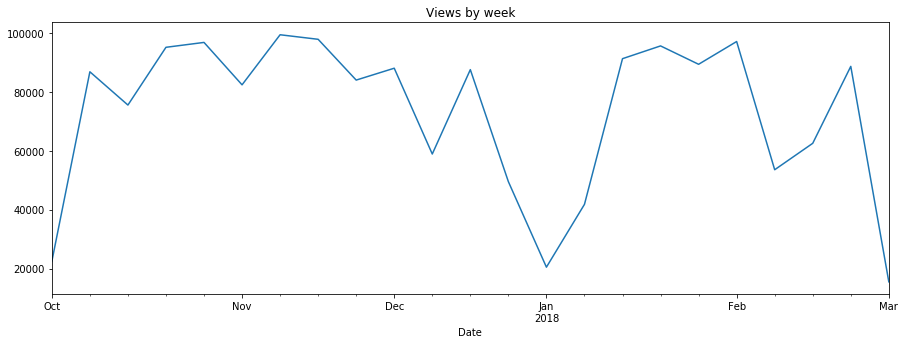

In [34]:
res_views.plot(x='Date', y='count_viewed', figsize = (15,5), title = 'Views by week')
plt.show()

## 3.2 Análisis de las visualizaciones de un usuario en una asignaura por fecha
### Consulta con el número de visualizaciones de un usuario en una asignatura por fecha

In [35]:
sparql.setQuery("""
SELECT (COUNT(*) AS ?count_viewed) ?userid ?courseid ?timecreated
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action. FILTER (?action = 'viewed')
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel. FILTER (?edulevel = 2)
    ?x <http://khaos.uma.es/ontologies/moodle/recordUser> ?userid.
    ?x <http://khaos.uma.es/ontologies/moodle/recordCourse> ?courseid.
    ?x <http://khaos.uma.es/ontologies/moodle/logtimecreated> ?timecreated.
}GROUP BY ?action ?edulevel ?userid ?courseid ?timecreated

""")

#### Conversión de los resultados a formato CSV

In [36]:
sparql.setReturnFormat(CSV)
results_log_view = sparql.query().convert()
s=str(results_log_view,'utf-8')
data = StringIO(s)

#### *Datos disponibles en: \datos\3-Análisis temporal\results_log_view.csv*

In [37]:
results_log_view = pd.read_csv(data)
results_log_view.head()

,count_viewed,userid,courseid,timecreated
0,1,http://khaos.uma.es/ontologies/moodle/user7867,http://khaos.uma.es/ontologies/moodle/course78,2017-12-03T11:26:21
1,1,http://khaos.uma.es/ontologies/moodle/user5609,http://khaos.uma.es/ontologies/moodle/course2,2017-11-02T19:14:20
2,1,http://khaos.uma.es/ontologies/moodle/user1463,http://khaos.uma.es/ontologies/moodle/course8,2017-12-09T11:20:29
3,1,http://khaos.uma.es/ontologies/moodle/user12380,http://khaos.uma.es/ontologies/moodle/course22,2017-12-17T21:29:49
4,1,http://khaos.uma.es/ontologies/moodle/user15556,http://khaos.uma.es/ontologies/moodle/course129,2018-01-31T12:14:09


#### Agrupación de los resultados por semanas

#### *Datos disponibles en: \datos\3-Análisis temporal\results_log_view_group.csv*

In [38]:
results_log_view['Date'] = pd.to_datetime(results_log_view['timecreated'])
df = results_log_view.groupby(['userid','courseid', pd.Grouper(key='Date', freq='W-MON')])['count_viewed']\
    .sum()\
    .reset_index()\
    .sort_values('Date')

### Representación del número de visualizaciones por semana de un usuario en un curso

#### Gráficas disponibles en: \datos\3-Análisis temporal\plot_views_user_course

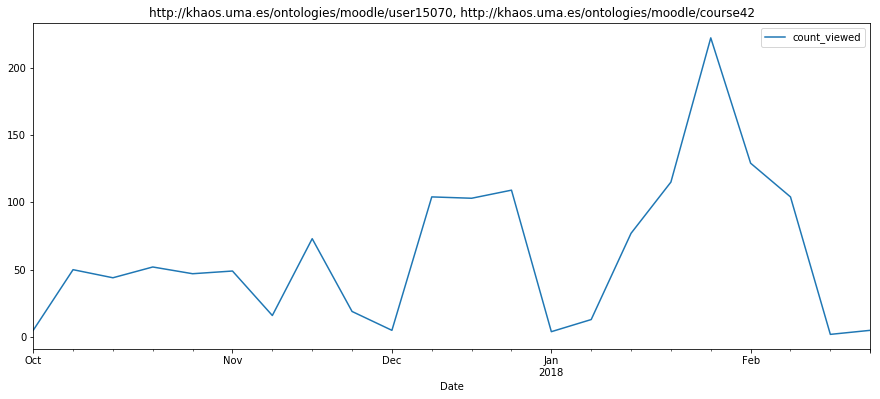

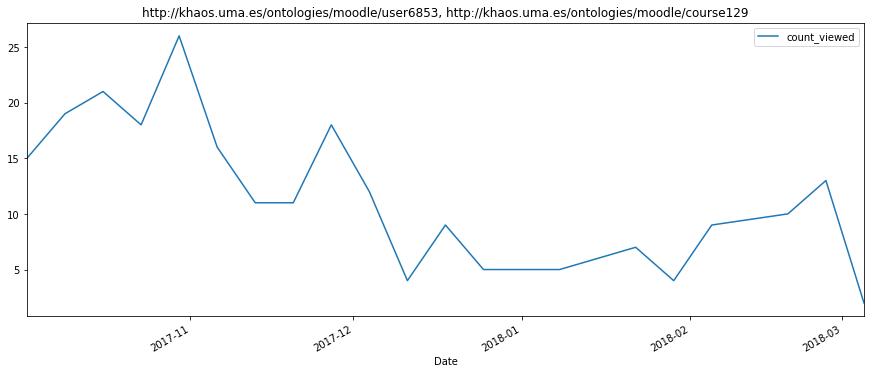

In [39]:
unique_values=df[['userid', 'courseid']].drop_duplicates().head(2)
for index, row in unique_values.iterrows():
    data_xy = df[df['userid'] == row['userid']]
    data_xy = data_xy[data_xy['courseid'] == row['courseid']]
    data_xy.plot(x='Date', y='count_viewed',title= row['userid']+', '+row['courseid'], figsize = (15,6))
    plt.show()

## 3.3 Análisis de las entregas por fecha
### Consulta con el número de entregas por fecha

In [40]:
sparql.setQuery("""
SELECT (COUNT(*) AS ?count_submitted) ?timecreated
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action. FILTER (?action = 'submitted')
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel. FILTER (?edulevel = 2)
    ?x <http://khaos.uma.es/ontologies/moodle/logtimecreated> ?timecreated.
}GROUP BY ?action ?edulevel ?timecreated

""")

#### Conversión de los resultados a formato CSV

In [41]:
sparql.setReturnFormat(CSV)
results_log_view = sparql.query().convert()
s=str(results_log_view,'utf-8')
data = StringIO(s)

In [42]:
results_log_count_submitted = pd.read_csv(data)
results_log_count_submitted.head()

,count_submitted,timecreated
0,1,2018-02-20T15:36:55
1,1,2017-12-09T16:24:39
2,1,2017-11-24T14:28:07
3,1,2017-11-04T22:01:37
4,1,2017-10-11T10:57:28


#### Agrupación de los resultados por semanas

In [43]:
results_log_count_submitted['Date'] = pd.to_datetime(results_log_count_submitted['timecreated'])
result_count_sub = results_log_count_submitted[['count_submitted', 'Date']]
res_sub = result_count_sub.groupby([pd.Grouper(key='Date', freq='W-MON')])['count_submitted'].sum()
res_sub

Date
2017-10-02      39
2017-10-09     279
2017-10-16     530
2017-10-23     900
2017-10-30     792
2017-11-06     853
2017-11-13     836
2017-11-20    1038
2017-11-27     710
2017-12-04     894
2017-12-11     383
2017-12-18     560
2017-12-25     298
2018-01-01      69
2018-01-08     226
2018-01-15    1129
2018-01-22    1090
2018-01-29     784
2018-02-05     574
2018-02-12     158
2018-02-19     188
2018-02-26     505
2018-03-05      35
Freq: W-MON, Name: count_submitted, dtype: int64

###  Representación del número de entregas por semana

[]

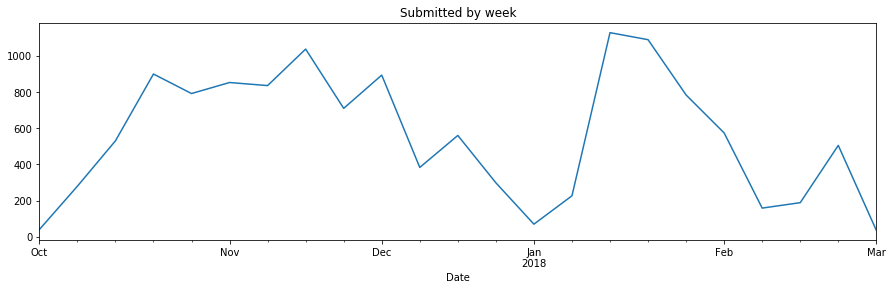

In [44]:
res_sub.plot(x='Date', y='count_submitted', figsize = (15,4), title = 'Submitted by week')
plt.plot()

## 3.4 Análisis de las entregas de un usuario en una asignaura por fecha
### Consulta con el número de entregas de un usuario en una asignatura por fecha

In [45]:
sparql.setQuery("""
SELECT (COUNT(*) AS ?count_submitted) ?userid ?courseid ?timecreated
WHERE
  { ?x <http://khaos.uma.es/ontologies/moodle/logaction> ?action. FILTER (?action = 'submitted')
    ?x <http://khaos.uma.es/ontologies/moodle/logedulevel> ?edulevel. FILTER (?edulevel = 2)
    ?x <http://khaos.uma.es/ontologies/moodle/recordUser> ?userid.
    ?x <http://khaos.uma.es/ontologies/moodle/recordCourse> ?courseid.
    ?x <http://khaos.uma.es/ontologies/moodle/logtimecreated> ?timecreated.
}GROUP BY ?action ?edulevel ?userid ?courseid ?timecreated
""")

#### Conversión de los resultados a formato CSV

In [46]:
sparql.setReturnFormat(CSV)
results_log_view = sparql.query().convert()
s=str(results_log_view,'utf-8')
data = StringIO(s)

#### *Datos disponibles en: \datos\3-Análisis temporal\results_log_count_submitted_alu.csv*

In [47]:
results_log_count_submitted_alu = pd.read_csv(data)
results_log_count_submitted_alu.head()

,count_submitted,userid,courseid,timecreated
0,1,http://khaos.uma.es/ontologies/moodle/user10577,http://khaos.uma.es/ontologies/moodle/course1,2017-12-03T20:55:05
1,1,http://khaos.uma.es/ontologies/moodle/user8951,http://khaos.uma.es/ontologies/moodle/course81,2017-11-02T18:32:22
2,1,http://khaos.uma.es/ontologies/moodle/user3932,http://khaos.uma.es/ontologies/moodle/course1,2017-11-19T18:49:12
3,1,http://khaos.uma.es/ontologies/moodle/user12875,http://khaos.uma.es/ontologies/moodle/course42,2017-10-19T20:11:34
4,1,http://khaos.uma.es/ontologies/moodle/user381,http://khaos.uma.es/ontologies/moodle/course58,2017-11-14T12:14:38


#### Agrupación de los resultados por semanas

#### *Datos disponibles en: \datos\3-Análisis temporal\results_log_count_submitted_alu_group.csv*

In [48]:
results_log_count_submitted_alu['Date'] = pd.to_datetime(results_log_count_submitted_alu['timecreated'])
df = results_log_count_submitted_alu.groupby(['userid','courseid', pd.Grouper(key='Date', freq='W-MON')])['count_submitted']\
    .sum()\
    .reset_index()\
    .sort_values('Date')

### Representación del número de entregas por semana de un usuario en un curso

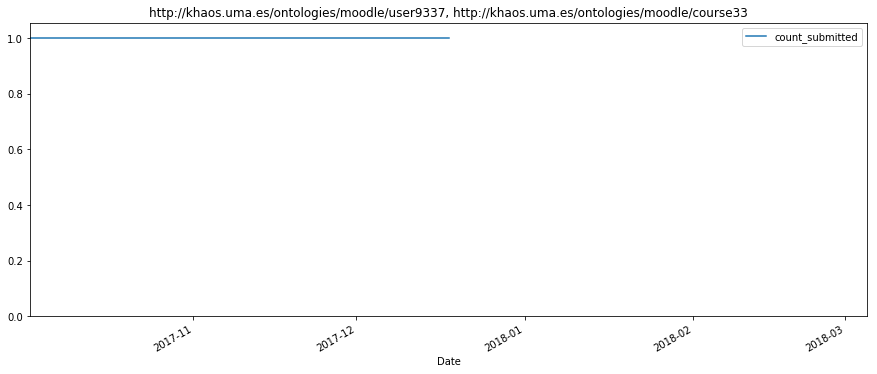

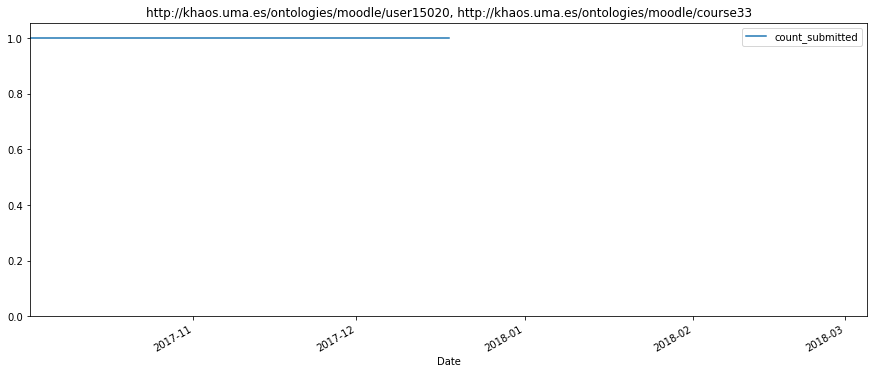

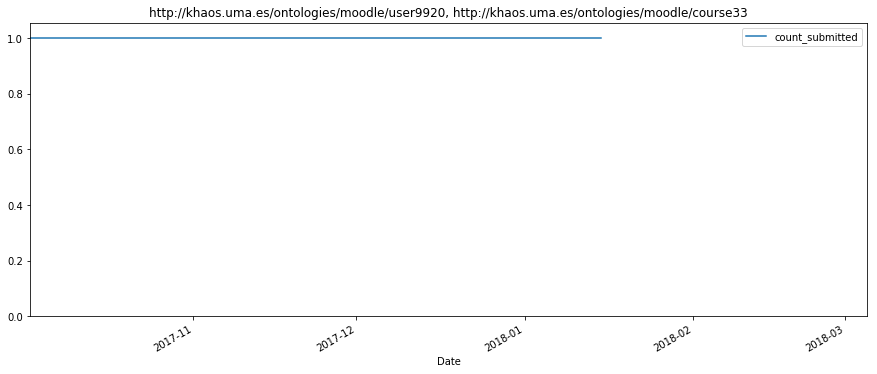

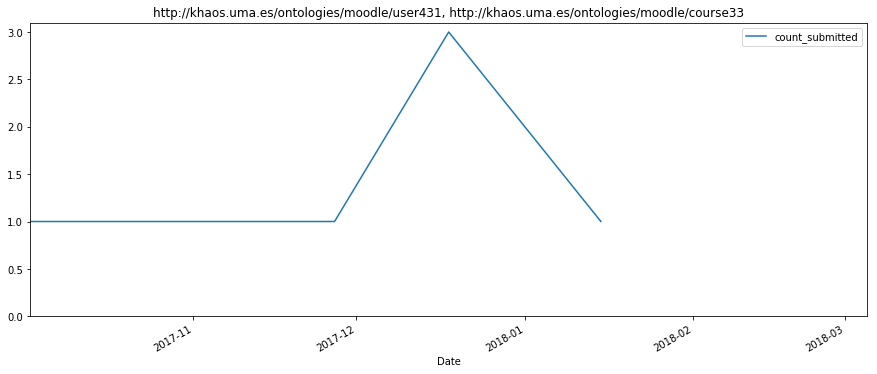

In [49]:
unique_values=df[['userid', 'courseid']].drop_duplicates().head(4)
min_value = min(df['Date'])
max_value = max(df['Date'])
for index, row in unique_values.iterrows():
    data_xy = df[df['userid'] == row['userid']]
    data_xy = data_xy[data_xy['courseid'] == row['courseid']]
    data_xy.plot(x='Date', y='count_submitted',title= str(row['userid'])+', '+str(row['courseid']), figsize = (15,6))
    plt.ylim(bottom=0)
    plt.xlim(left=min_value)
    plt.xlim(right=max_value)
    plt.show()